In [1]:
import io

import numpy as np
import tensorflow as tf

from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import object_detection_evaluation as obj_det_eval

from object_detection.utils import label_map_util

from matplotlib import pyplot as plt

from PIL import Image

%matplotlib inline

In [2]:
pascal_tfrecord_fname = "./data/pascal.record"
record_iterator = tf.python_io.tf_record_iterator(path=pascal_tfrecord_fname)

In [3]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile('./models/ssd_inception_v2_coco_11_06_2017/frozen_inference_graph.pb', 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [4]:
config = tf.ConfigProto(
    device_count = {'GPU': 0},
)
sess = tf.InteractiveSession(graph=detection_graph, config=config)

In [5]:
# Truncate input because cluster is loaded now
i = 0

all_data = []
for string_record in record_iterator:
    i += 1
    if i == 10:
        break
        
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    raw_img = example.features.feature['image/encoded'].bytes_list.value[0]
    height = example.features.feature['image/height'].int64_list.value[0]
    width = example.features.feature['image/width'].int64_list.value[0]
    labels = example.features.feature['image/object/class/label'].int64_list.value
    xmin = example.features.feature['image/object/bbox/xmin'].float_list.value
    xmax = example.features.feature['image/object/bbox/xmax'].float_list.value
    ymin = example.features.feature['image/object/bbox/ymin'].float_list.value
    ymax = example.features.feature['image/object/bbox/ymax'].float_list.value
    
    
    raw_img = tf.image.decode_image(raw_img).eval()
    
    all_data.append((raw_img, height, width, labels, xmin, xmax, ymin, ymax))

In [6]:
coco_to_pascal = {5:1, 2:2, 16:3, 9:4, 44:5, 6:6, 3:7, 17:8, 62:9, 21:10, 67:11, 
                  18:12, 19:13, 4:14, 1:15, 64:16, 20:17, 63:18, 7:19, 72:20}

label_map = label_map_util.load_labelmap("/home/mkoltsov/models/research/object_detection/data/mscoco_label_map.pbtxt")
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


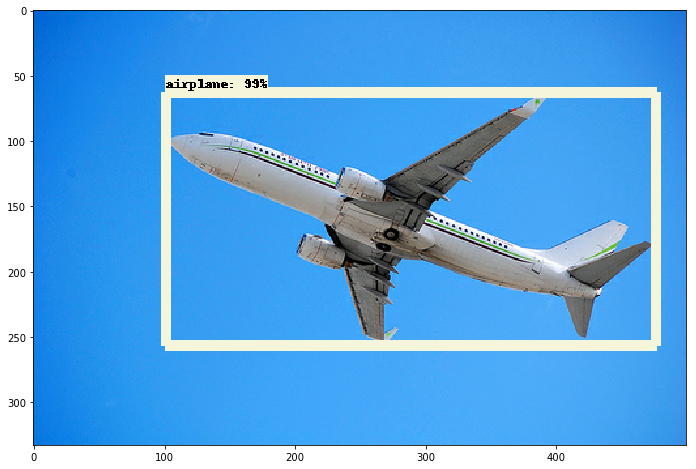

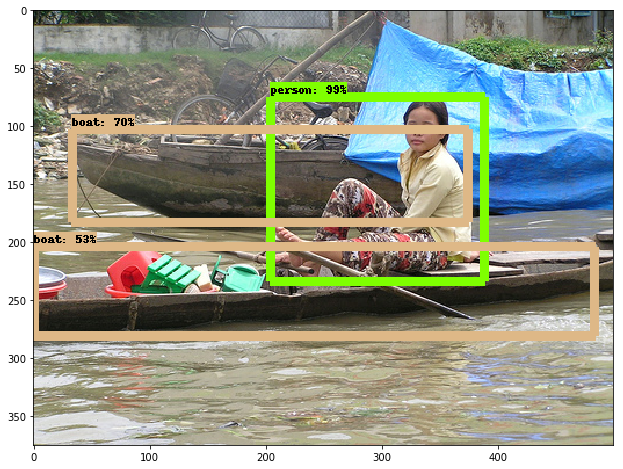

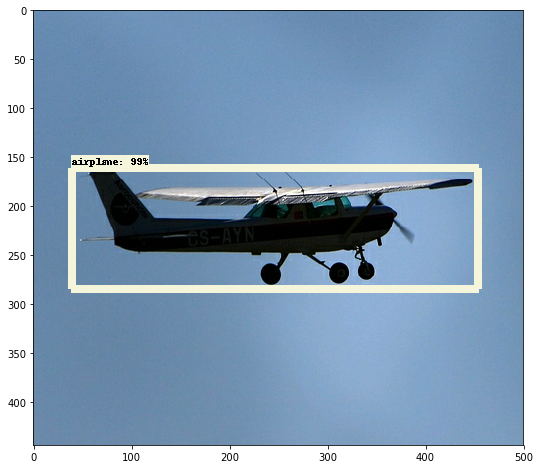

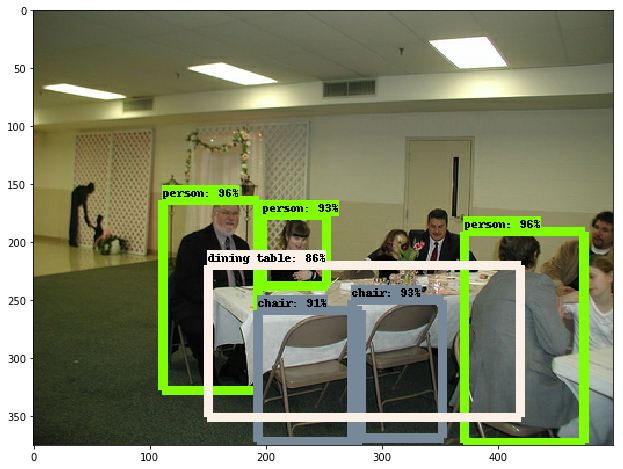

In [7]:
eval_result = obj_det_eval.ObjectDetectionEvaluation(20)

# https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
with detection_graph.as_default():
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
    img_key = 1
    for img, height, width, labels, xmin, xmax, ymin, ymax in all_data[5:10]:
        img_key += 1
        
        image_np_expanded = np.expand_dims(img, axis=0)
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded}
        )
        boxes = np.squeeze(boxes)
        classes = np.squeeze(classes).astype(np.int32)
        scores = np.squeeze(scores)
        
        only_pascal_classes = []
        for cls in classes:
            only_pascal_classes.append(cls in coco_to_pascal.keys())
        only_pascal_classes = np.array(only_pascal_classes)
        
        classes = classes[only_pascal_classes]
        boxes = boxes[only_pascal_classes]
        scores = scores[only_pascal_classes]
        
        vis_util.visualize_boxes_and_labels_on_image_array(
            img,
            boxes,
            classes,
            scores,
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8
        )
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        
        labels = np.array(labels)

        # Does not work for some reason :(
        if False:
            rr = np.hstack((ymin, xmin, ymax, xmax))
            rr.resize((len(labels), 4))
            eval_result.add_single_ground_truth_image_info(str(img_key), 
                                                      rr,
                                                      labels)
        
            eval_result.add_single_detected_image_info(str(img_key),
                                                  detected_boxes=boxes, 
                                                   detected_scores=scores, 
                                                   detected_class_labels=classes)
        
#print(eval_result.evaluate())
